# Content Based Recommender

In [15]:
%load_ext Cython
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as pyplot
import optuna as op
%matplotlib inline
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Utils.createURM import createURM
from Utils.createICM import createICM
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [10]:
URM = createURM()
ICM = createICM()

C:\Users\Mike\PycharmProjects\recsys-challenge-2022-Pancini-Vitali\Utils\createURM.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../Input/interactions_and_impressions.csv')
C:\Users\Mike\PycharmProjects\recsys-challenge-2022-Pancini-Vitali\Utils\createICM.py:14: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  URM = pd.read_csv('../Input/interactions_and_impressions.csv')


In [11]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

In [12]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2655 ( 6.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1547 ( 3.7%) Users that have less than 1 test interactions


# Neighbors

In [16]:
x_tick = [10, 25, 40, 50, 100]
MAP_per_k = []

for topK in x_tick:

    recommender = ItemKNNCBFRecommender(URM_train, ICM)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 4 ( 0.0%) users with no interactions.
ItemKNNCBFRecommender: ICM Detected 4877 (19.9%) items with no features.
Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2932.04 column/sec. Elapsed time 8.36 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 20.07 sec. Users per second: 1942
ItemKNNCBFRecommender: URM Detected 4 ( 0.0%) users with no interactions.
ItemKNNCBFRecommender: ICM Detected 4877 (19.9%) items with no features.
Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 3194.78 column/sec. Elapsed time 7.67 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 18.54 sec. Users per second: 2102
ItemKNNCBFRecommender: URM Detected 4 ( 0.0%) users with no interactions.
ItemKNNCBFRecommender: ICM Detected 4877 (19.9%) items with no features.
Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 3124.10 column/sec. Elapsed time 7.84 sec
EvaluatorHoldout: Processed 38974 (100.0%) in

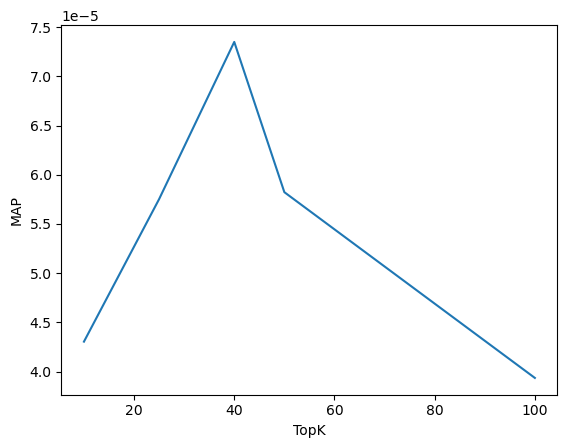

In [17]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

Let's take topK=45

# Shrinkage

In [18]:
x_tick = [0, 10, 50, 100, 200]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = ItemKNNCBFRecommender(URM_train, ICM)
    recommender.fit(shrink=shrink, topK=45)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 4 ( 0.0%) users with no interactions.
ItemKNNCBFRecommender: ICM Detected 4877 (19.9%) items with no features.
Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2369.75 column/sec. Elapsed time 10.34 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 20.15 sec. Users per second: 1934
ItemKNNCBFRecommender: URM Detected 4 ( 0.0%) users with no interactions.
ItemKNNCBFRecommender: ICM Detected 4877 (19.9%) items with no features.
Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2663.21 column/sec. Elapsed time 9.20 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 20.04 sec. Users per second: 1945
ItemKNNCBFRecommender: URM Detected 4 ( 0.0%) users with no interactions.
ItemKNNCBFRecommender: ICM Detected 4877 (19.9%) items with no features.
Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 3037.77 column/sec. Elapsed time 8.07 sec
EvaluatorHoldout: Processed 38974 (100.0%) i

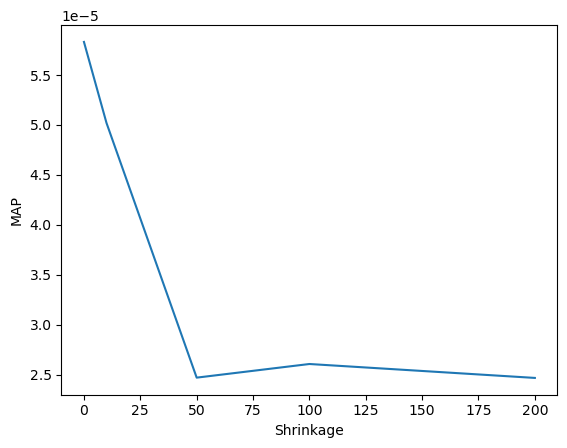

In [19]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

# Optuna optimization

In [20]:
recommender = ItemKNNCBFRecommender(URM_train, ICM)

def objective(trial):
    topK = trial.suggest_float("topK", 20, 30)
    shrink = trial.suggest_float("shrink", 15, 30)
    recommender.fit(topK=int(topK), shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

ItemKNNCBFRecommender: URM Detected 4 ( 0.0%) users with no interactions.
ItemKNNCBFRecommender: ICM Detected 4877 (19.9%) items with no features.


In [21]:
study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

[I 2022-11-04 18:56:37,771] A new study created in memory with name: no-name-276e2133-2537-4338-ac45-5fcf533ab816


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2642.32 column/sec. Elapsed time 9.27 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 19.64 sec. Users per second: 1984


[I 2022-11-04 18:57:06,724] Trial 0 finished with value: 4.1987698758879544e-05 and parameters: {'topK': 24.847153091712542, 'shrink': 22.012197494637043}. Best is trial 0 with value: 4.1987698758879544e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2473.15 column/sec. Elapsed time 9.91 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 19.12 sec. Users per second: 2038


[I 2022-11-04 18:57:35,785] Trial 1 finished with value: 3.9393376618193155e-05 and parameters: {'topK': 22.401501425931805, 'shrink': 26.793994383464355}. Best is trial 1 with value: 3.9393376618193155e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2802.87 column/sec. Elapsed time 8.74 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 18.61 sec. Users per second: 2094


[I 2022-11-04 18:58:03,167] Trial 2 finished with value: 4.048690172772894e-05 and parameters: {'topK': 29.159430183875514, 'shrink': 26.07439184769368}. Best is trial 1 with value: 3.9393376618193155e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2861.08 column/sec. Elapsed time 8.57 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 19.80 sec. Users per second: 1969


[I 2022-11-04 18:58:31,558] Trial 3 finished with value: 5.602330735753019e-05 and parameters: {'topK': 29.090689335157304, 'shrink': 22.738844850826712}. Best is trial 1 with value: 3.9393376618193155e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2807.92 column/sec. Elapsed time 8.73 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 19.39 sec. Users per second: 2010


[I 2022-11-04 18:58:59,698] Trial 4 finished with value: 2.7529545541553538e-05 and parameters: {'topK': 20.76030330382823, 'shrink': 21.726768509649}. Best is trial 4 with value: 2.7529545541553538e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2795.58 column/sec. Elapsed time 8.77 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 19.41 sec. Users per second: 2008


[I 2022-11-04 18:59:27,898] Trial 5 finished with value: 3.340037029163113e-05 and parameters: {'topK': 23.967179492775816, 'shrink': 19.536125576299757}. Best is trial 4 with value: 2.7529545541553538e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2927.05 column/sec. Elapsed time 8.37 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 19.24 sec. Users per second: 2025


[I 2022-11-04 18:59:55,546] Trial 6 finished with value: 4.528558314415552e-05 and parameters: {'topK': 21.94519400298361, 'shrink': 28.06152532535406}. Best is trial 4 with value: 2.7529545541553538e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2675.19 column/sec. Elapsed time 9.16 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 18.55 sec. Users per second: 2101


[I 2022-11-04 19:00:23,280] Trial 7 finished with value: 4.028733848613769e-05 and parameters: {'topK': 26.71485122105296, 'shrink': 16.707608197369886}. Best is trial 4 with value: 2.7529545541553538e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2626.20 column/sec. Elapsed time 9.33 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 24.09 sec. Users per second: 1618


[I 2022-11-04 19:00:56,735] Trial 8 finished with value: 4.364020458083166e-05 and parameters: {'topK': 28.153474195961955, 'shrink': 20.51918765009151}. Best is trial 4 with value: 2.7529545541553538e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2646.24 column/sec. Elapsed time 9.26 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 18.83 sec. Users per second: 2070


[I 2022-11-04 19:01:24,855] Trial 9 finished with value: 3.583687456269177e-05 and parameters: {'topK': 25.949858196975647, 'shrink': 21.228536995148428}. Best is trial 4 with value: 2.7529545541553538e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2883.52 column/sec. Elapsed time 8.50 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 19.53 sec. Users per second: 1996


[I 2022-11-04 19:01:52,916] Trial 10 finished with value: 5.6481488269346847e-05 and parameters: {'topK': 20.054836324677957, 'shrink': 15.253304336384584}. Best is trial 4 with value: 2.7529545541553538e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2841.35 column/sec. Elapsed time 8.63 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 19.74 sec. Users per second: 1974


[I 2022-11-04 19:02:21,318] Trial 11 finished with value: 2.7306564164469436e-05 and parameters: {'topK': 23.52526158379014, 'shrink': 18.044930875443463}. Best is trial 11 with value: 2.7306564164469436e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2355.44 column/sec. Elapsed time 10.40 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 21.99 sec. Users per second: 1772


[I 2022-11-04 19:02:53,738] Trial 12 finished with value: 3.301448014590109e-05 and parameters: {'topK': 20.29577011453744, 'shrink': 17.90749331215975}. Best is trial 11 with value: 2.7306564164469436e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2673.23 column/sec. Elapsed time 9.17 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 21.88 sec. Users per second: 1781


[I 2022-11-04 19:03:24,819] Trial 13 finished with value: 2.6607074639095985e-05 and parameters: {'topK': 22.601403333483844, 'shrink': 24.453692628426108}. Best is trial 13 with value: 2.6607074639095985e-05.


Compute_Similarity: detected dense matrix
Similarity column 24507 (100.0%), 2472.88 column/sec. Elapsed time 9.91 sec
EvaluatorHoldout: Processed 38974 (100.0%) in 19.73 sec. Users per second: 1976


[I 2022-11-04 19:03:54,489] Trial 14 finished with value: 3.902886824834789e-05 and parameters: {'topK': 23.727064996762135, 'shrink': 24.519328151996053}. Best is trial 13 with value: 2.6607074639095985e-05.


In [22]:
topK = study.best_params['topK']
shrink = study.best_params['shrink']

In [23]:
topK

22.601403333483844

In [24]:
shrink

24.453692628426108